In [1]:
import pandas as pd
import numpy as np
import tweepy
import json
import re
import requests
import math
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
from scipy import signal
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # Don't print matching warnings. 
init_notebook_mode() # Use plotly in offline mode.

# Gathering Data

In [2]:
# Key, secrets and token for accessing Twitter's api.
consumer_key = 'xxxxxxxxxxxxxxxxxxxxx'
consumer_secret = 'xxxxxxxxxxxxxxxxxxxxx'
access_token = 'xxxxxxxxxxxxxxxxxxxxx'
access_secret = 'xxxxxxxxxxxxxxxxxxxxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [3]:
# Downloading and saving image-predictions.tsv to disk.
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

with open('image-predictions.tsv', 'wb') as f:
    f.write(r.content)

In [4]:
# Reading image-predictions.tsv and twitter-archive-enhanced.csv to panda dataframes.
image_predictions = pd.read_csv('image-predictions.tsv', delimiter = '\t', encoding = 'utf-8')
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv', encoding = 'utf-8')

In [5]:
# Extract tweet json data to txt file.
with open('tweet_json.txt', 'w+') as tweet_json:
    count_down = len(twitter_archive.tweet_id.unique())
    for tweet_id in twitter_archive.tweet_id.unique():
        try:
            tj = json.dumps(api.get_status(tweet_id, tweet_mode='extended')._json)
            tweet_json.write(tj)
            tweet_json.write('\r\n')
        except:
            pass
        print(count_down)
        count_down = count_down - 1

"# Extract tweet json data to txt file.\nwith open('tweet_json.txt', 'w+') as tweet_json:\n    count_down = len(twitter_archive.tweet_id.unique())\n    for tweet_id in twitter_archive.tweet_id.unique():\n        try:\n            tj = json.dumps(api.get_status(tweet_id, tweet_mode='extended')._json)\n            tweet_json.write(tj)\n            tweet_json.write('\r\n')\n        except:\n            pass\n        print(count_down)\n        count_down = count_down - 1"

In [5]:
# Extract desired data from tweet_json.txt file.
with open('tweet_json.txt') as file:
    data = []
    tweet_json_data = pd.DataFrame
    for line in file:
        data.append([json.loads(line)['id'], json.loads(line)['retweet_count'], json.loads(line)['favorite_count']])

In [6]:
# Create pandas dataframe and fill with tweet_json.txt data.
tweet_json_data = pd.DataFrame(index = range(len(data)), columns = ['tweet_id', 'retweet_count', 'favorite_count'])
n = 0
for row in data:
    tweet_json_data['tweet_id'][n] = row[0]
    tweet_json_data['retweet_count'][n] = row[1]
    tweet_json_data['favorite_count'][n] = row[2]
    n += 1

# Assessing Data

In [7]:
# Looking at top 5 rows of twitter_archive's data.
twitter_archive.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [8]:
# Looking at top 5 rows of image_predictions's data.
image_predictions.head()

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   
3        1     Rhodesian_ridgeback  0.408143    True             redbone   
4        1      miniature_pinscher  0.560311    True          Rottweiler   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True  
3  0.360687    True   miniature_pinscher  0.222752    True  
4  0.243682    True             Doberman  0.154629    True

In [9]:
# Looking at top 5 rows of tweet_json_data's data.
tweet_json_data.head()

tweet_id retweet_count favorite_count
0  892420643555336193          8327          38073
1  892177421306343426          6151          32679
2  891815181378084864          4069          24589
3  891689557279858688          8471          41429
4  891327558926688256          9166          39599

In [10]:
# View summary of twitter_archive dataframe.
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
# View all values that are not all lowercase in twitter_archive's 'name' column along with their count.
twitter_archive[twitter_archive['name'].str.islower() == False]['name'].value_counts()

None          745
Charlie        12
Lucy           11
Oliver         11
Cooper         11
Tucker         10
Penny          10
Lola           10
Bo              9
Winston         9
Sadie           8
Buddy           7
Bailey          7
Daisy           7
Toby            7
Stanley         6
Bella           6
Oscar           6
Milo            6
Scout           6
Jax             6
Jack            6
Koda            6
Rusty           6
Leo             6
Dave            6
Sammy           5
Louis           5
Alfie           5
Phil            5
             ... 
Smiley          1
Bobb            1
Berkeley        1
O               1
Horace          1
Storkson        1
Molly           1
Crumpet         1
Monster         1
Tiger           1
Mya             1
Lassie          1
Banjo           1
Chuq            1
Dixie           1
River           1
Link            1
Jaspers         1
Bruno           1
Sora            1
Chesterson      1
Godzilla        1
Humphrey        1
Terrenth        1
Brat      

In [12]:
# View all values that are all lowercase in twitter_archive's 'name' column along with their count.
twitter_archive[twitter_archive['name'].str.islower() == True]['name'].value_counts()

a               55
the              8
an               7
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
such             1
by               1
life             1
light            1
space            1
incredibly       1
old              1
infuriating      1
this             1
unacceptable     1
my               1
officially       1
his              1
all              1
Name: name, dtype: int64

In [13]:
# View all values in twitter_archive's 'doggo' column along with their count.
twitter_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [14]:
# View summary of image_predictions dataframe.
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
# View summary of tweet_json_data dataframe.
tweet_json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null object
retweet_count     2340 non-null object
favorite_count    2340 non-null object
dtypes: object(3)
memory usage: 54.9+ KB


In [16]:
# View descriptive statistics of twitter_archive dataframe.
twitter_archive.describe()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
count  2.356000e+03           7.800000e+01         7.800000e+01   
mean   7.427716e+17           7.455079e+17         2.014171e+16   
std    6.856705e+16           7.582492e+16         1.252797e+17   
min    6.660209e+17           6.658147e+17         1.185634e+07   
25%    6.783989e+17           6.757419e+17         3.086374e+08   
50%    7.196279e+17           7.038708e+17         4.196984e+09   
75%    7.993373e+17           8.257804e+17         4.196984e+09   
max    8.924206e+17           8.862664e+17         8.405479e+17   

       retweeted_status_id  retweeted_status_user_id  rating_numerator  \
count         1.810000e+02              1.810000e+02       2356.000000   
mean          7.720400e+17              1.241698e+16         13.126486   
std           6.236928e+16              9.599254e+16         45.876648   
min           6.661041e+17              7.832140e+05          0.000000   
25%           7.186315e+17              4.196984e+09         10.000000   
50%           7.804657e+17              4.196984e+09         11.000000   
75%           8.203146e+17              4.196984e+09         12.000000   
max           8.874740e+17              7.874618e+17       1776.000000   

       rating_denominator  
count         2356.000000  
mean            10.455433  
std              6.745237  
min              0.000000  
25%             10.000000  
50%             10.000000  
75%             10.000000  
max            170.000000

In [17]:
# View all values in twitter_archive's 'rating_numerator' column along with their count sorted by 'rating_numerator'.
twitter_archive['rating_numerator'].value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [18]:
# View all values in twitter_archive's 'rating_denominator' column along with their count sorted by 'rating_denominator'.
twitter_archive['rating_denominator'].value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [19]:
# View descriptive statistics of image_predictions dataframe.
image_predictions.describe()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

### Things to fix

##### Quality

1) Convert twitter_archive['timestamp'] and twitter_archive['retweeted_status_timestamp'] to date type.

2) Convert all id columns in twitter_archive to strings.

3) Convert image_predictions['img_num'] to strings.

4) Convert all id columns in image_predictions to strings.

5) Convert all id columns in tweet_json to strings.

6) Convert tweet_json['retweet_count'] and tweet_json['favorite_count'] to integers.

7) Fix names in twitter_archive_clean['name'] that are not names (Ex: 'a', 'the', 'an', etc.) or replace remaining lowercase values in twitter_archive_clean['name'] that are not names with NaN..

8) Replace all 'None' values in twitter_archive_clean with NaN.

9) Find the true rating_numerator and rating_denominator, then replace old one with the correct one or change rating_numerator and rating_denominator of tweets with no true rating to Nan.

10) All ratings seem to use a denominator of 10, but they sometimes rate multiple dogs and multiply the rating by the number of dogs. I would like to revert those ratings to a denominator of 10 and its corresponding numerator. I would then create a new 'multiplier' column that would show the number of dogs rated. Ex: a rating_numerator:20 and a rating_denominator:20 rating would be changed to rating_numerator:10, a rating_denominator:10 and a multiplier:2.

11) Melt doggo, floofer, pupper, and puppo columns into one dog_stage column.

12) Replace all values that have a string 'nan' with a true NaN.

13) Remove all rows that has data in the retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns since they are not real tweets but retweets, which we do not want.

##### Tidiness

1) tweet_json_data and image_predictions_clean should be merged into twitter_archive.

2) Since twitter_archive['rating_denominator'] is always 10 (see value_counts code below), then that column is not needed.

3) Remove 'doggo', 'floofer', 'pupper' and 'puppo' columns. Since the ‘dog_stage’ column has all the same data, the 'doggo', 'floofer', 'pupper' and 'puppo' columns are redundant.

4) Remove 'retweeted_status_id','retweeted_status_user_id' and 'retweeted_status_timestamp' columns since they no longer have any data.

# Cleaning Data

### Quality

##### Define

- Convert twitter_archive['timestamp'] and twitter_archive['retweeted_status_timestamp'] to date type.
- Convert all id columns in twitter_archive to strings.

##### Code

In [20]:
# Make clean copies of each dataframe.
twitter_archive_clean = twitter_archive.copy()
tweet_json_data_clean = tweet_json_data.copy()
image_predictions_clean = image_predictions.copy()

In [21]:
# Converting data types of twitter_archive_clean.
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
twitter_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(twitter_archive_clean['retweeted_status_timestamp'])
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean['in_reply_to_status_id'] = twitter_archive_clean['in_reply_to_status_id'].astype(str)
twitter_archive_clean['in_reply_to_user_id'] = twitter_archive_clean['in_reply_to_user_id'].astype(str)
twitter_archive_clean['retweeted_status_id'] = twitter_archive_clean['retweeted_status_id'].astype(str)
twitter_archive_clean['retweeted_status_user_id'] = twitter_archive_clean['retweeted_status_user_id'].astype(str)

##### Test

In [22]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datet

##### Define
- Convert image_predictions['img_num'] to strings.
- Convert all id columns in image_predictions to strings.

##### Code

In [23]:
# Converting data types of image_predictions_clean.
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)
image_predictions_clean['img_num'] = image_predictions_clean['img_num'].astype(str)

##### Test

In [24]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null object
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), object(6)
memory usage: 152.1+ KB


##### Define
- Convert tweet_json['retweet_count'] and tweet_json['favorite_count'] to integers.
- Convert all id columns in tweet_json to strings.

##### Code

In [25]:
# Converting data types of tweet_json_data_clean.
tweet_json_data_clean['tweet_id'] = tweet_json_data_clean['tweet_id'].astype(str)
tweet_json_data_clean['retweet_count'] = tweet_json_data_clean['retweet_count'].astype(int)
tweet_json_data_clean['favorite_count'] = tweet_json_data_clean['favorite_count'].astype(int)

##### Test

In [26]:
tweet_json_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null object
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


##### Define
- Fix names in twitter_archive_clean['name'] that are not names (Ex: 'a', 'the', 'an', etc.) programmatically.

##### Code

In [27]:
# Fix names in twitter_archive_clean['name'] that are not names (Ex: 'a', 'the', 'an', etc.) programmatically.
for tweet_id in twitter_archive_clean[twitter_archive_clean['name'].str.islower() == True]['tweet_id']:
    if 'named ' in twitter_archive_clean[twitter_archive_clean['tweet_id'] == tweet_id]['text'].tolist()[0]:
        match = re.search(r'[n][a][m][e][d]\s(\w+)[\.\s]', 
                          twitter_archive_clean[twitter_archive_clean['tweet_id'] == tweet_id]['text'].tolist()[0])
        twitter_archive_clean.loc[twitter_archive_clean.tweet_id == tweet_id, 'name'] = match.group(1)

##### Test

In [28]:
twitter_archive_clean[twitter_archive_clean['name'].str.islower() == True]['name'].value_counts()

a               36
the              8
an               6
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
such             1
by               1
life             1
light            1
space            1
incredibly       1
old              1
infuriating      1
this             1
unacceptable     1
my               1
officially       1
his              1
all              1
Name: name, dtype: int64

##### Define
- Fix names in twitter_archive_clean['name'] that are not names (Ex: 'a', 'the', 'an', etc.) that could not be fixed programmatically.

##### Code

In [29]:
# Fix names in twitter_archive_clean['name'] that are not names (Ex: 'a', 'the', 'an', etc.) that could not be 
# fixed programmatically.
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == '667177989038297088', 'name'] = 'Daryl'
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == '748692773788876800', 'name'] = 'Quizno'
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == '776201521193218000', 'name'] = "O'Malley"

##### Test

In [30]:
print(twitter_archive_clean.loc[twitter_archive_clean.tweet_id == '667177989038297088']['name'])
print(twitter_archive_clean.loc[twitter_archive_clean.tweet_id == '748692773788876800']['name'])

2287    Daryl
Name: name, dtype: object
992    Quizno
Name: name, dtype: object


##### Define
- Replace remaining lowercase values in twitter_archive_clean['name'] that are not names (Ex: 'a', 'the', 'an', etc.) with NaN.

##### Code

In [31]:
#  Replace remaining lowercase values in twitter_archive_clean['name'] that are not names (Ex: 'a', 'the', 'an', etc.) with NaN.
for tweet_id in twitter_archive_clean[twitter_archive_clean['name'].str.islower() == True]['tweet_id']:
    twitter_archive_clean.loc[twitter_archive_clean.tweet_id == tweet_id, 'name'] = np.nan

##### Test

In [32]:
twitter_archive_clean[twitter_archive_clean['name'].str.islower() == True]['name'].value_counts()

Series([], Name: name, dtype: int64)

##### Define
- Replace all 'None' values in twitter_archive_clean with NaN.

##### Code

In [33]:
#  Replace all 'None' values in twitter_archive_clean with NaN.
twitter_archive_clean = twitter_archive_clean.replace('None', np.nan)

##### Test

In [34]:
print(twitter_archive_clean.loc[twitter_archive_clean['name'] == 'None']['name'].value_counts())
print(twitter_archive_clean.loc[twitter_archive_clean['doggo'] == 'None']['doggo'].value_counts())
print(twitter_archive_clean.loc[twitter_archive_clean['floofer'] == 'None']['floofer'].value_counts())
print(twitter_archive_clean.loc[twitter_archive_clean['pupper'] == 'None']['pupper'].value_counts())
print(twitter_archive_clean.loc[twitter_archive_clean['puppo'] == 'None']['puppo'].value_counts())

Series([], Name: name, dtype: int64)
Series([], Name: doggo, dtype: int64)
Series([], Name: floofer, dtype: int64)
Series([], Name: pupper, dtype: int64)
Series([], Name: puppo, dtype: int64)


##### Define
- Find the true rating_numerator and rating_denominator, then replace old one with the correct one.

##### Code

In [35]:
# Find the true rating_numerator and rating_denominator, then replace old one with the correct one.
for text in twitter_archive_clean['text']:
    match = re.search(r'(\d+\.?\d?\d?\d?\d?/\d+)\D*(\d+\.?\d?\d?\d?\d?/\d+)?', text) # grab all fractions
    if match.group(2) == None:
        numerator, denominator = match.group(1).split('/') # if there is only one group, grab the one fraction and split it.
    else:
        numerator, denominator = match.group(2).split('/') # if there are two groups, grab the second fraction and split it.
    if twitter_archive_clean.loc[twitter_archive_clean.text == text, 
                                 'rating_numerator'].values[0] != float(numerator):
        twitter_archive_clean.loc[twitter_archive_clean.text == text,       # Convert to float then round and convert to integer
                            'rating_numerator'] = float(numerator)
    if twitter_archive_clean.loc[twitter_archive_clean.text == text, 'rating_denominator'].values[0] != int(denominator):
        twitter_archive_clean.loc[twitter_archive_clean.text == text, 
                                  'rating_denominator'] = int(denominator) # Convert to integer

##### Test

In [36]:
twitter_archive_clean['rating_numerator'].value_counts().sort_index()

0.00         2
1.00         9
2.00        10
3.00        19
4.00        17
5.00        34
6.00        33
7.00        57
8.00       104
9.00       156
9.50         1
9.75         2
10.00      454
11.00      467
11.26        1
11.27        1
12.00      556
13.00      355
13.50        1
14.00       56
15.00        2
20.00        1
24.00        1
44.00        1
45.00        1
60.00        1
80.00        1
84.00        1
88.00        1
99.00        1
121.00       1
143.00       1
144.00       1
165.00       1
182.00       1
204.00       1
420.00       2
666.00       1
1776.00      1
Name: rating_numerator, dtype: int64

In [37]:
twitter_archive_clean['rating_denominator'].value_counts().sort_index()

7         1
10     2340
15        1
16        1
20        1
40        1
50        2
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

##### Define
- Change rating_numerator and rating_denominator of tweets with no true rating to Nan.

##### Code

In [38]:
# Change rating_numerator and rating_denominator of tweets with no true rating to Nan.
twitter_archive_clean.loc[twitter_archive_clean.rating_denominator == 15, 'rating_numerator'] = np.nan
twitter_archive_clean.loc[twitter_archive_clean.rating_denominator == 15, 'rating_denominator'] = np.nan
twitter_archive_clean.loc[twitter_archive_clean.rating_denominator == 16, 'rating_numerator'] = np.nan
twitter_archive_clean.loc[twitter_archive_clean.rating_denominator == 16, 'rating_denominator'] = np.nan
twitter_archive_clean.loc[twitter_archive_clean.rating_denominator == 7, 'rating_numerator'] = np.nan
twitter_archive_clean.loc[twitter_archive_clean.rating_denominator == 7, 'rating_denominator'] = np.nan

##### Test

In [39]:
twitter_archive_clean['rating_denominator'].value_counts().sort_index()

10.0     2340
20.0        1
40.0        1
50.0        2
70.0        1
80.0        2
90.0        1
110.0       1
120.0       1
130.0       1
150.0       1
170.0       1
Name: rating_denominator, dtype: int64

##### Define
- All ratings seem to use a denominator of 10, but they sometimes rate multiple dogs and multiply the rating by the number of dogs. I would like to revert those ratings to a denominator of 10 and its corresponding numerator. I would then create a new 'multiplier' column that would show the number of dogs rated. Ex: a rating_numerator:20 and a rating_denominator:20 rating would be changed to rating_numerator:10, a rating_denominator:10 and a multiplier:2.

###### Code

In [40]:
# Create multiplier column
twitter_archive_clean['multiplier'] = float(1)
cols = twitter_archive_clean.columns.tolist()
cols = cols[:12] + cols[-1:] + cols[12:-1]
twitter_archive_clean = twitter_archive_clean[cols]

##### Test

In [41]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2353 non-null float64
rating_denominator            2353 non-null float64
multiplier                    2356 non-null float64
name                          1524 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo        

##### Code

In [42]:
# Divide twitter_archive_clean['rating_denominator'] (if not Nan) by 10 and put answer in corresponding 
# twitter_archive_clean['multiplier'] column.
for denominator in twitter_archive_clean['rating_denominator']:
    if math.isnan(denominator) == False:
        if denominator != 10:
            multiplier = denominator/10
            twitter_archive_clean.loc[twitter_archive_clean.rating_denominator == denominator, 'multiplier'] = multiplier
    else:
        twitter_archive_clean.loc[pd.isnull(twitter_archive_clean.rating_denominator), 'multiplier'] = np.nan

##### Test

In [43]:
twitter_archive_clean['multiplier'].value_counts().sort_index()    

1.0     2340
2.0        1
4.0        1
5.0        2
7.0        1
8.0        2
9.0        1
11.0       1
12.0       1
13.0       1
15.0       1
17.0       1
Name: multiplier, dtype: int64

##### Code

In [44]:
# If twitter_archive_clean['multiplier'] is greater than 1, change twitter_archive_clean['rating_numerator'] to 
#    twitter_archive_clean['rating_numerator']/twitter_archive_clean['multiplier'] and 
#    twitter_archive_clean['rating_denominator'] to 
#    twitter_archive_clean['rating_denominator']/twitter_archive_clean['multiplier'].

for tweet_id in twitter_archive_clean['tweet_id']:
    multiplier = twitter_archive_clean.loc[twitter_archive_clean.tweet_id == tweet_id]['multiplier'].values[0]
    if multiplier > 1:
        numerator = twitter_archive_clean.loc[twitter_archive_clean.tweet_id == tweet_id]['rating_numerator'].values[0]
        denominator = twitter_archive_clean.loc[twitter_archive_clean.tweet_id == tweet_id]['rating_denominator'].values[0]
        twitter_archive_clean.loc[twitter_archive_clean.tweet_id == tweet_id, 'rating_numerator'] = numerator/multiplier
        twitter_archive_clean.loc[twitter_archive_clean.tweet_id == tweet_id, 'rating_denominator'] = denominator/multiplier

##### Test

In [45]:
twitter_archive_clean.rating_denominator.value_counts().sort_index()

10.0    2353
Name: rating_denominator, dtype: int64

In [46]:
twitter_archive_clean.rating_numerator.value_counts().sort_index()

0.00         2
1.00         9
2.00        11
3.00        19
4.00        16
5.00        34
6.00        33
7.00        57
8.00       104
9.00       157
9.50         1
9.75         2
10.00      455
11.00      472
11.26        1
11.27        1
12.00      560
13.00      355
13.50        1
14.00       56
15.00        2
182.00       1
420.00       2
666.00       1
1776.00      1
Name: rating_numerator, dtype: int64

##### Define
- Melt doggo, floofer, pupper, and puppo columns into one dog_stage column.

##### Code

In [47]:
# Melt doggo, floofer, pupper, and puppo columns into one dog_stage column.
dog_stage_mix = twitter_archive_clean.melt(id_vars = ['tweet_id'], value_vars = ['doggo', 'floofer', 'pupper', 'puppo'],
                                     value_name = 'dog_stage').dropna(subset = ['dog_stage']).drop('variable', 1)
dog_stage_uni = dog_stage_mix[dog_stage_mix.duplicated(subset = 'tweet_id') == False]
dog_stage_dup = dog_stage_mix[dog_stage_mix.duplicated(subset = 'tweet_id') == True]
dog_stage = pd.merge(dog_stage_uni, dog_stage_dup, how = 'left', on = 'tweet_id')
dog_stage['dog_stage'] = dog_stage[['dog_stage_x', 'dog_stage_y']].apply(lambda x: ','.join(x.dropna()), axis = 1)
twitter_archive_clean = pd.merge(twitter_archive_clean, dog_stage[['tweet_id', 'dog_stage']], how = 'left', on = 'tweet_id')

##### Test

In [48]:
twitter_archive_clean.dog_stage.value_counts()

pupper           245
doggo             83
puppo             29
doggo,pupper      12
floofer            9
doggo,puppo        1
doggo,floofer      1
Name: dog_stage, dtype: int64

##### Define
- Replace all values that have a string 'nan' with a true NaN.

##### Code

In [49]:
# Replace all 'nan' values with NaN
twitter_archive_clean = twitter_archive_clean.replace('nan', np.nan)

##### Test

In [50]:
print(twitter_archive_clean.loc[twitter_archive_clean['retweeted_status_id'] == 'nan']['retweeted_status_id'].value_counts())

Series([], Name: retweeted_status_id, dtype: int64)


##### Define
- Remove all rows that has data in the retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns.

##### Code

In [52]:
# Remove all rows that has data in the retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns.
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_id'])]

##### Test

In [53]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2172 non-null float64
rating_denominator            2172 non-null float64
multiplier                    2172 non-null float64
name                          1413 non-null object
doggo                         87 non-null object
floofer                       10 non-null object
pupper                        234 non-null object
puppo                    

### Tidiness

##### Define
- tweet_json_data and image_predictions_clean should be merged into twitter_archive.

##### Code

In [54]:
# Merging tweet_json_data_clean into twitter_archive_clean.
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_json_data_clean, how = 'left', on = 'tweet_id')

In [55]:
# Merge image_predictions_clean data into twitter_archive_clean.
twitter_archive_clean = pd.merge(twitter_archive_clean, image_predictions_clean, how = 'left', on = 'tweet_id')

##### Test

In [56]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 32 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_numerator              2172 non-null float64
rating_denominator            2172 non-null float64
multiplier                    2172 non-null float64
name                          1413 non-null object
doggo                         87 non-null object
floofer                       10 non-null object
pupper                        234 non-null object
puppo                    

##### Define
- Since twitter_archive['rating_denominator'] is always 10 (see value_counts code below), then that column is not needed.

##### Code

In [57]:
# View value count of rating_denominator
twitter_archive_clean['rating_denominator'].value_counts(dropna = False)

 10.0    2172
NaN         3
Name: rating_denominator, dtype: int64

In [58]:
# Remove rating_denominator column and rename rating_numerator column to rating_out_of_10

twitter_archive_clean = twitter_archive_clean.drop('rating_denominator', axis = 1)

twitter_archive_clean = twitter_archive_clean.rename(index = int, columns = {'rating_numerator' : 'rating_out_of_10'})

##### Test

In [59]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 31 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_out_of_10              2172 non-null float64
multiplier                    2172 non-null float64
name                          1413 non-null object
doggo                         87 non-null object
floofer                       10 non-null object
pupper                        234 non-null object
puppo                         25 non-null object
dog_stage                   

##### Define
- Remove 'doggo', 'floofer', 'pupper' and 'puppo' columns. Since the ‘dog_stage’ column has all the same data, the 'doggo', 'floofer', 'pupper' and 'puppo' columns are redundant.

##### Code

In [60]:
# Remove 'doggo', 'floofer', 'pupper' and 'puppo' columns.
twitter_archive_clean = twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], 1)

##### Test

In [61]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 27 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 2117 non-null object
rating_out_of_10              2172 non-null float64
multiplier                    2172 non-null float64
name                          1413 non-null object
dog_stage                     344 non-null object
retweet_count                 2173 non-null float64
favorite_count                2173 non-null float64
jpg_url                       1994 non-null object
img_num             

##### Define
- Remove 'retweeted_status_id','retweeted_status_user_id' and 'retweeted_status_timestamp' columns.

##### Code

In [62]:
# Remove 'retweeted_status_id','retweeted_status_user_id' and 'retweeted_status_timestamp' columns.
twitter_archive_clean = twitter_archive_clean.drop(['retweeted_status_id','retweeted_status_user_id', 
                                                    'retweeted_status_timestamp'], 1)

##### Test

In [63]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 24 columns):
tweet_id                 2175 non-null object
in_reply_to_status_id    78 non-null object
in_reply_to_user_id      78 non-null object
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_out_of_10         2172 non-null float64
multiplier               2172 non-null float64
name                     1413 non-null object
dog_stage                344 non-null object
retweet_count            2173 non-null float64
favorite_count           2173 non-null float64
jpg_url                  1994 non-null object
img_num                  1994 non-null object
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-null object
p2_conf    

# Storing Data

In [64]:
# Storing clean datasets as csv files

twitter_archive_clean.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index = False)

# Analysis and Visualization of Data

In [65]:
# Extract csv data for analysis and visualization

twitter_archive_master = pd.read_csv('twitter_archive_master.csv', encoding = 'utf-8')

In [66]:
# View summary of twitter_archive_master dataframe.
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 24 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_out_of_10         2172 non-null float64
multiplier               2172 non-null float64
name                     1413 non-null object
dog_stage                344 non-null object
retweet_count            2173 non-null float64
favorite_count           2173 non-null float64
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-null object
p2_conf          

I noticed that the 'timestamp' column needs to be converted from an object to datetime again.

In [67]:
# covert twitter_archive_master['timestamp'] from object to datetime
twitter_archive_master['timestamp'] = pd.to_datetime(twitter_archive_master['timestamp'])

# test changes
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 24 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_out_of_10         2172 non-null float64
multiplier               2172 non-null float64
name                     1413 non-null object
dog_stage                344 non-null object
retweet_count            2173 non-null float64
favorite_count           2173 non-null float64
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-null object
p2_conf  

In [68]:
# View descriptive statistics of twitter_archive_master's 'rating_out_of_10' column.
twitter_archive_master['rating_out_of_10'].describe()

count    2172.000000
mean       12.181989
std        42.470890
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_out_of_10, dtype: float64

In the table above, there are some very extreme outliers in each column. Since the mean and the median are relatively close for the first three columns, I can assume that outliers for those columns are high but few. For the 'favorite_count' column, the mean is much higher than the median. From this I can conclude that the outliers for this column are not few and so have a strong pull on the mean. Every statistic seems to decrease with each prediction.

Text(0.5,1,'Histogram of Tweets by Month')

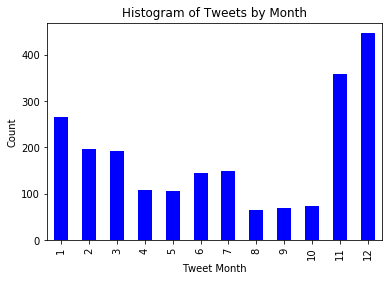

In [69]:
# Histogram of timestamp by month.
twitter_archive_master['timestamp'].groupby(twitter_archive_master['timestamp'].dt.month).count().plot(kind = 'bar', 
                                                                                                       color = 'blue')
plt.ylabel('Count')
plt.xlabel('Tweet Month')
plt.title('Histogram of Tweets by Month')
#plt.savefig('01 - Number of Tweets by Month.png', bbox_inches = 'tight')

This bar plot shows that this twitter account is more active in the late fall and early winter.

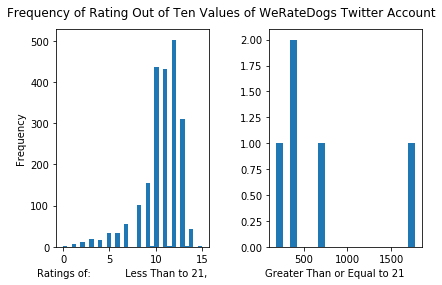

In [70]:
# Histogram of rating_out_of_10 values less than 21.
plt.subplot(1, 2, 1)
twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 21]['rating_out_of_10'].plot.hist(bins = 32)
plt.xlabel('Ratings of:           Less Than to 21,       ')
plt.subplot(1, 2, 2)
twitter_archive_master[twitter_archive_master['rating_out_of_10'] >= 21]['rating_out_of_10'].plot.hist(bins = 20)
plt.xlabel('Greater Than or Equal to 21       ')
plt.ylabel('')
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.suptitle('Frequency of Rating Out of Ten Values of WeRateDogs Twitter Account')
#plt.savefig('02 - Frequency of Rating Out of Ten.png', bbox_inches = 'tight')
plt.show()

It looks as though most ratings are either a 10/10, a 11/10, a 12/10 or a 13/10.

In [71]:
# View all values in twitter_archive_master's 'dog_stage' column along with their count.
twitter_archive_master['dog_stage'].value_counts(dropna = False)

NaN              1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

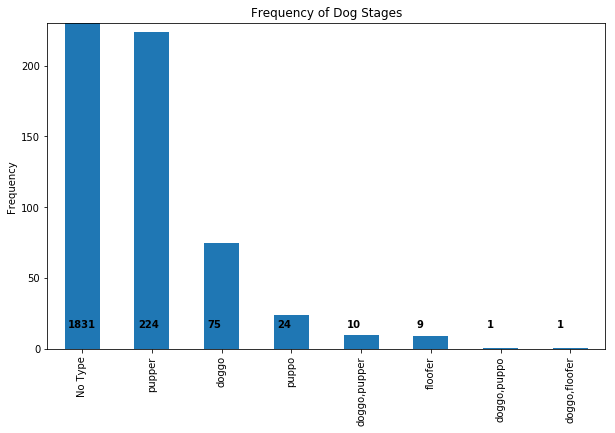

In [72]:
# Bar plot of dog_stage
fig, ax = plt.subplots(figsize = (10, 6))
twitter_archive_master['dog_stage'].value_counts(dropna = False).plot(kind = 'bar')
loc, labels = plt.xticks()
labels[0] = 'No Type'
plt.ylim(0, 230)
plt.xticks(loc, labels)
plt.title('Frequency of Dog Stages')
plt.ylabel('Frequency')
for i, v in enumerate(twitter_archive_master['dog_stage'].value_counts(dropna = False)):
    ax.text(i - 0.2, 15, str(v), color = 'black', fontweight = 'bold')
#plt.savefig('03 - Frequency of Dog Stages.png', bbox_inches = 'tight')

While most tweets have no dog stage, of the ones that do have a dog stage, 'pupper' is far and above the most used.

Text(0.5,0,'Number of Retweets')

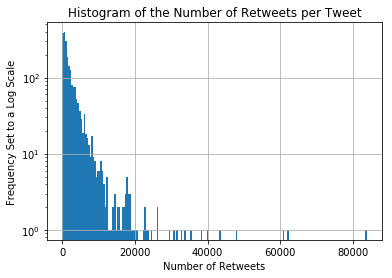

In [73]:
# Histogram of retweet_count.
fig, ax = plt.subplots()
twitter_archive_master['retweet_count'].hist(ax = ax, bins = 200, log = True)
plt.title('Histogram of the Number of Retweets per Tweet')
plt.ylabel('Frequency Set to a Log Scale')
plt.xlabel('Number of Retweets')
#plt.savefig('04 - Histogram of the Number of Retweets per Tweet.png', bbox_inches = 'tight')

Text(0.5,0,'Number of Favorites')

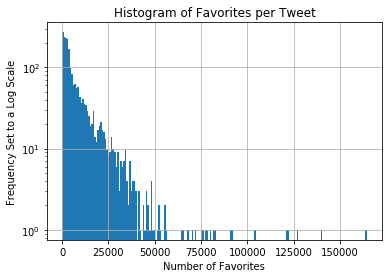

In [74]:
# Histogram of favorite_count.
fig, ax = plt.subplots()
twitter_archive_master['favorite_count'].hist(ax = ax, bins = 200, log = True)
plt.title('Histogram of Favorites per Tweet')
plt.ylabel('Frequency Set to a Log Scale')
plt.xlabel('Number of Favorites')
#plt.savefig('05 - Histogram of Favorites per Tweet.png', bbox_inches = 'tight')

The exponential decrease in the number of retweets and number of favorites is to be expected.

In [75]:
# Line plot of 'rating_out_of_10' vs 'timestamp' with a Savgol filter line placed on top.
data = [Scatter(x = twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 100]['timestamp'], 
                y = twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 100]['rating_out_of_10'],
                name = 'Dog Rating Out of 10'),
        Scatter(x = twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 100]['timestamp'], 
                y = signal.savgol_filter(
                    twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 100]['rating_out_of_10'], 53, 3),
                name = '<br>Dog Rating Out of 10<br>with a Savitzky-Golay<br>Filter')]
layout = Layout(title = 'WeRateDogs Ratings (Out of Ten) From November 2015 to July 2017<br>(For Ratings Less Than 100)')
fig = Figure(data = data, layout = layout)
iplot(fig)

The above plot shows that this Twitter account has seen a gradual increase in the ratings it gives to dogs over the past two years.

In [76]:
# Line plot of 'retweet_count' vs 'timestamp' with a Savgol filter line placed on top.
data = [Scatter(x = twitter_archive_master[twitter_archive_master['retweet_count'] >= 0]['timestamp'], 
                y = twitter_archive_master[twitter_archive_master['retweet_count'] >= 0]['retweet_count'],
                name = 'Retweet Count'),
        Scatter(x = twitter_archive_master[twitter_archive_master['retweet_count'] >= 0]['timestamp'], 
                y = signal.savgol_filter(
                    twitter_archive_master[twitter_archive_master['retweet_count'] >= 0]['retweet_count'], 53, 3),
                name = '<br>Retweet Count with<br>a Savitzky-Golay<br>Filter')]
layout = Layout(title = 'Retweet Count of WeRateDogs from November 2015 to July 2017')
fig = Figure(data = data, layout = layout)
iplot(fig)

In [77]:
# Line plot of 'favorite_count' vs 'timestamp' with a Savgol filter line placed on top.
data = [Scatter(x = twitter_archive_master[twitter_archive_master['favorite_count'] >= 0]['timestamp'], 
                y = twitter_archive_master[twitter_archive_master['favorite_count'] >= 0]['favorite_count'],
                name = 'Favorite Count'),
        Scatter(x = twitter_archive_master[twitter_archive_master['favorite_count'] >= 0]['timestamp'], 
                y = signal.savgol_filter(
                    twitter_archive_master[twitter_archive_master['favorite_count'] >= 0]['favorite_count'], 53, 3),
                name = '<br>Favorite Count with<br>a Savitzky-Golay<br>Filter')]
layout = Layout(title = 'Favorite Count of WeRateDogs from November 2015 to July 2017')
fig = Figure(data = data, layout = layout)
iplot(fig)

These two line plots show the increase of retweets and favorites over the past two years for WeRateDogs.

In [78]:
# Create jitter
# Source:
# https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s = 20, c = 'b', marker = 'o', cmap = None, norm = None, vmin = None, vmax = None, 
           alpha = None, linewidths = None, verts = None, hold = None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s = s, c = c, marker = marker, cmap = cmap, norm = norm, vmin = vmin,
                       vmax = vmax, alpha = alpha, linewidths = linewidths, verts = verts, hold = hold, **kwargs)

In [79]:
twitter_archive_master['dog_stage'].value_counts()

pupper           224
doggo             75
puppo             24
doggo,pupper      10
floofer            9
doggo,puppo        1
doggo,floofer      1
Name: dog_stage, dtype: int64

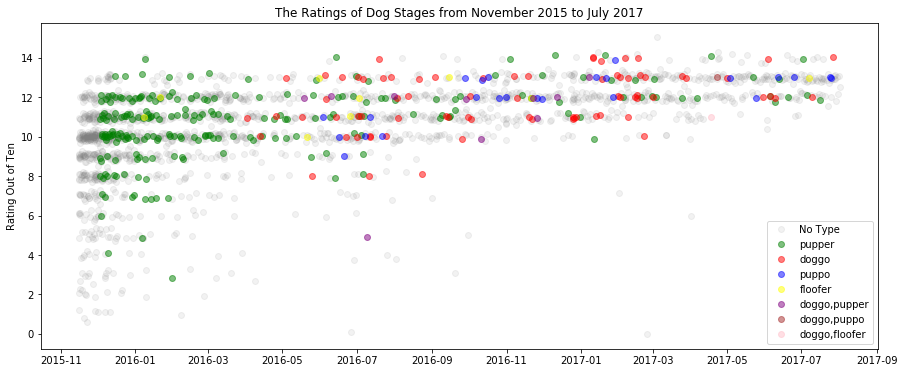

In [80]:
# Scatterplot of twitter_archive_master's 'rating_out_of_10' column by date colored by 'dog_stage'.
plt.figure(figsize = (15, 6))
plt.plot_date(x = twitter_archive_master[pd.isnull(twitter_archive_master['dog_stage'])]
              [twitter_archive_master[pd.isnull(twitter_archive_master['dog_stage'])]['rating_out_of_10'] < 100]['timestamp'],
              y = rand_jitter(twitter_archive_master[pd.isnull(twitter_archive_master['dog_stage'])]
                              [twitter_archive_master[pd.isnull(twitter_archive_master['dog_stage'])]
                               ['rating_out_of_10'] < 100]['rating_out_of_10']),
              c = 'grey', marker = 'o', alpha = 0.1, label = 'No Type')
plt.plot_date(x = twitter_archive_master[twitter_archive_master['dog_stage'] == 'pupper']['timestamp'],
              y = rand_jitter(twitter_archive_master[twitter_archive_master['dog_stage'] == 'pupper']['rating_out_of_10']),
              c = 'green', marker = 'o', alpha = 0.5, label = 'pupper')
plt.plot_date(x = twitter_archive_master[twitter_archive_master['dog_stage'] == 'doggo']['timestamp'],
              y = rand_jitter(twitter_archive_master[twitter_archive_master['dog_stage'] == 'doggo']['rating_out_of_10']),
              c = 'red', marker = 'o', alpha = 0.5, label = 'doggo')
plt.plot_date(x = twitter_archive_master[twitter_archive_master['dog_stage'] == 'puppo']['timestamp'],
              y = rand_jitter(twitter_archive_master[twitter_archive_master['dog_stage'] == 'puppo']['rating_out_of_10']),
              c = 'blue', marker = 'o', alpha = 0.5, label = 'puppo')
plt.plot_date(x = twitter_archive_master[twitter_archive_master['dog_stage'] == 'floofer']['timestamp'],
              y = rand_jitter(twitter_archive_master[twitter_archive_master['dog_stage'] == 'floofer']['rating_out_of_10']),
              c = 'yellow', marker = 'o', alpha = 0.5, label = 'floofer')
plt.plot_date(x = twitter_archive_master[twitter_archive_master['dog_stage'] == 'doggo,pupper']['timestamp'],
              y = rand_jitter(twitter_archive_master[twitter_archive_master['dog_stage'] == 'doggo,pupper']['rating_out_of_10']),
              c = 'purple', marker = 'o', alpha = 0.5, label = 'doggo,pupper')
plt.plot_date(x = twitter_archive_master[twitter_archive_master['dog_stage'] == 'doggo,puppo']['timestamp'],
              y = rand_jitter(twitter_archive_master[twitter_archive_master['dog_stage'] == 'doggo,puppo']['rating_out_of_10']),
              c = 'brown', marker = 'o', alpha = 0.5, label = 'doggo,puppo')
plt.plot_date(x = twitter_archive_master[twitter_archive_master['dog_stage'] == 'doggo,floofer']['timestamp'],
              y = rand_jitter(twitter_archive_master[twitter_archive_master['dog_stage'] == 'doggo,floofer']['rating_out_of_10']),
              c = 'pink', marker = 'o', alpha = 0.5, label = 'doggo,floofer')
plt.legend()
plt.title('The Ratings of Dog Stages from November 2015 to July 2017')
plt.ylabel('Rating Out of Ten')
#plt.savefig('09 - Ratings of Dog Stages by date.png', bbox_inches = 'tight')
plt.show()

The above dot plot shows that as the giving of ratings below 10 decreased, the variety of dog stages given increased.

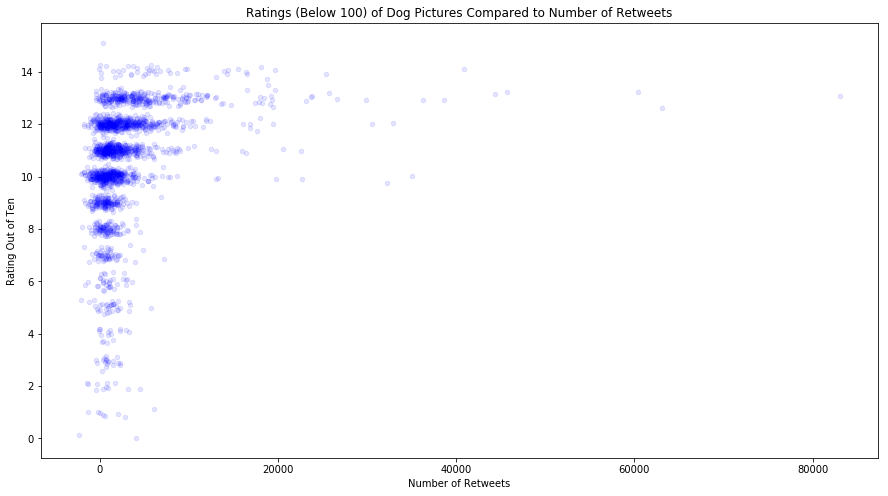

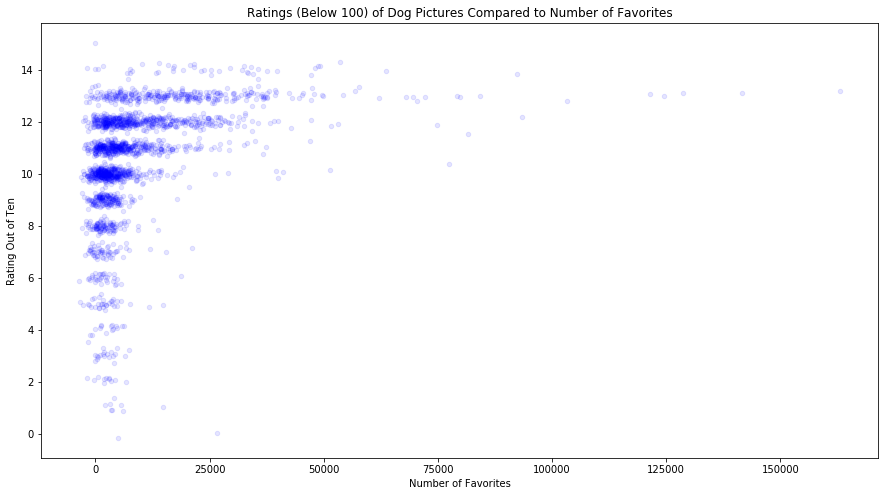

In [81]:
# Scatter plot of retweet_count vs rating_out_of_10 with values in rating_out_of_10 greater than 16 excluded.
plt.figure(figsize = (15, 8))
jitter(x = twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 100]['retweet_count'],
       y = twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 100]['rating_out_of_10'],
       alpha = 0.1)
plt.title('Ratings (Below 100) of Dog Pictures Compared to Number of Retweets')
plt.ylabel('Rating Out of Ten')
plt.xlabel('Number of Retweets')
#plt.savefig('10 - Ratings (Below 100) of Dog Pictures Compared to Number of Retweets.png', bbox_inches = 'tight')
plt.figure(figsize = (15, 8))
jitter(x = twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 100]['favorite_count'],
       y = twitter_archive_master[twitter_archive_master['rating_out_of_10'] < 100]['rating_out_of_10'],
       alpha = 0.1)
plt.title('Ratings (Below 100) of Dog Pictures Compared to Number of Favorites')
plt.ylabel('Rating Out of Ten')
plt.xlabel('Number of Favorites')
#plt.savefig('11 - Ratings (Below 100) of Dog Pictures Compared to Number of Favorites.png', bbox_inches = 'tight')
plt.show()

It looks as though most retweets and favorites occur in the 8 to 13 rating range. However, most ratings are in the 8 to 13 range, so I think it is just a coincidence.

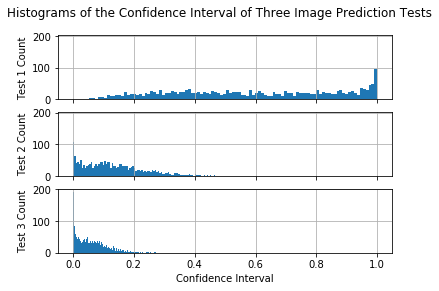

In [82]:
# Three histograms of twitter_archive_master['p1_conf'], twitter_archive_master['p2_conf'] and 
# twitter_archive_master['p3_conf'].
ax1 = plt.subplot(311)
twitter_archive_master['p1_conf'].hist(ax = ax1, bins = 100)
plt.setp(ax1.get_xticklabels(), visible = False)
plt.suptitle('Histograms of the Confidence Interval of Three Image Prediction Tests')
plt.ylabel('Test 1 Count')
ax2 = plt.subplot(312, sharex = ax1, sharey = ax1)
twitter_archive_master['p2_conf'].hist(ax = ax2, bins = 100)
plt.ylabel('Test 2 Count')
plt.setp(ax2.get_xticklabels(), visible = False)
ax3 = plt.subplot(313, sharex = ax1, sharey = ax1)
twitter_archive_master['p3_conf'].hist(ax = ax3, bins = 100)
plt.ylabel('Test 3 Count')
plt.xlabel('Confidence Interval')
#plt.savefig('12 - Histograms of the Confidence Interval of Three Image Prediction Tests.png', bbox_inches = 'tight')
plt.show()

Looking at these three histograms tells me that the overall confidence interval of the first test was the strongest and got subsequently lower with each following test. I want to look at these three tests in a different way.

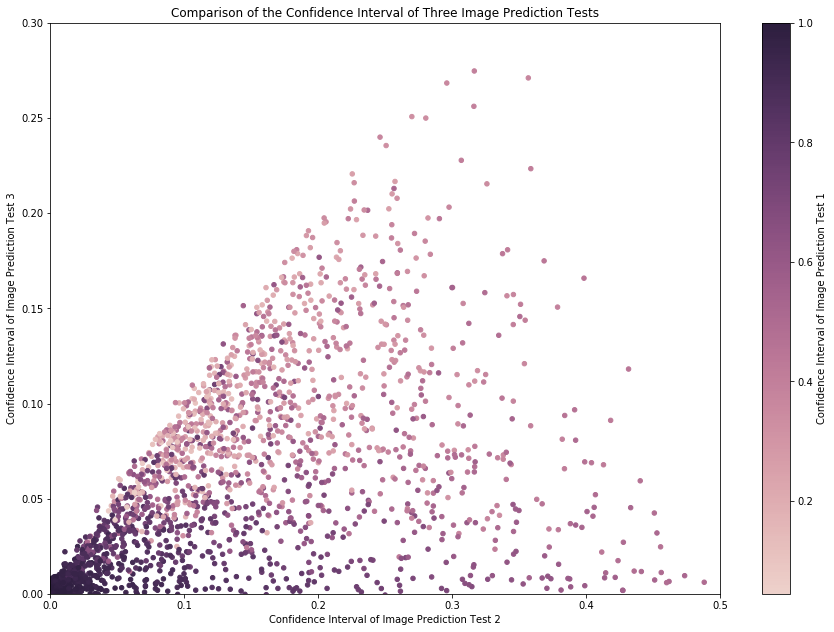

In [83]:
# Jittered scatterplot of twitter_archive_master['p2_conf'] and twitter_archive_master['p3_conf'] with
# twitter_archive_master['p1_conf'] as a color variable.
cmap = sns.cubehelix_palette(as_cmap = True)
fig, ax = plt.subplots(figsize = (15, 10.5))
points = jitter(x = twitter_archive_master['p2_conf'], y = twitter_archive_master['p3_conf'], 
                    c = twitter_archive_master['p1_conf'], cmap = cmap)
ax.set_title('Comparison of the Confidence Interval of Three Image Prediction Tests')
ax.set_xlim(0, 0.5)
ax.set_xlabel('Confidence Interval of Image Prediction Test 2')
ax.set_ylim(0, 0.3)
ax.set_ylabel('Confidence Interval of Image Prediction Test 3')
fig.colorbar(points, label = 'Confidence Interval of Image Prediction Test 1')
#plt.savefig('13 - Comparison of the Confidence Interval of Three Image Prediction Tests.png', bbox_inches = 'tight')

All the data for the second and third prediction tests are in the lower confidence interval range. While the first test is mostly in the higher confidence interval range. It also seems that data in the first test that are a confidence interval of 1 or close to 1 are mostly below 0.2 for the second test and 0.05 for the third test. I want to take a closer look.

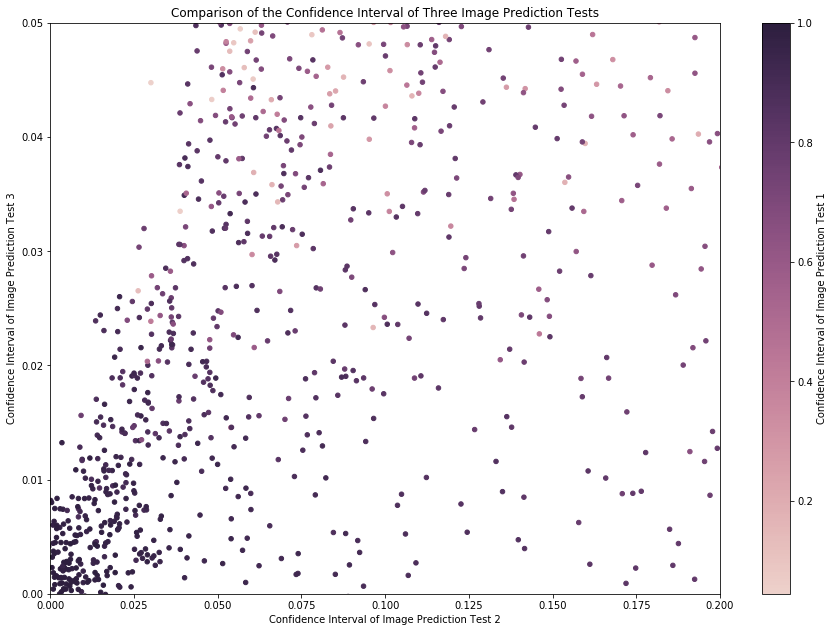

In [84]:
# Zoomed in on the previous scatterplot.
cmap = sns.cubehelix_palette(as_cmap = True)
fig, ax = plt.subplots(figsize = (15, 10.5))
points = jitter(x = twitter_archive_master['p2_conf'], y = twitter_archive_master['p3_conf'], 
                    c = twitter_archive_master['p1_conf'], cmap = cmap)
ax.set_title('Comparison of the Confidence Interval of Three Image Prediction Tests')
ax.set_xlim(0, 0.2)
ax.set_xlabel('Confidence Interval of Image Prediction Test 2')
ax.set_ylim(0, 0.05)
ax.set_ylabel('Confidence Interval of Image Prediction Test 3')
fig.colorbar(points, label = 'Confidence Interval of Image Prediction Test 1')
#plt.savefig('14 - Comparison of the Confidence Interval of Three Image Prediction Tests.png', bbox_inches = 'tight')

This zoomed in plot shows that a large portion of the data from test 1 that is or is close to a confidence interval of 1 is gathered in the lower bounds of the confidence interval for tests 2 and 3.